In [1]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)

In [2]:
import numpy as np
import matplotlib.pyplot as plt


import time
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

In [3]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta
from random import choices

def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import random, zeros

from numba import jit

dt = 0.01 # Time step.
T = 5 # Total time.
n = int(T / dt) # Number of time steps.

times = np.linspace(0., T, n)

J=1
N=5
    
refgamma=0.0  #Gamma phi
refdecay=0.0    #Gamma (solely)
refomega=0
    
Gamma_du=0  #Fixed
Gamma_phi=refgamma*J
Gamma_decay=refdecay*J
Omega=refomega*J
sqrt_2phi=  (2*Gamma_phi)**0.5
sqrt_decay= (Gamma_decay)**0.5
Stochastic=1   #Is the process stochastic?
sqrt_Gamma_phi = np.sqrt(Gamma_phi)

gama_sq= (  ((2*Gamma_phi)**0.5+ (Gamma_decay)**0.5  )**2 )/2



@jit

def trayectorystra(N=N,Stochastic=Stochastic):
    sqrtdt = np.sqrt(dt)*Stochastic
    
    Results = zeros((3*N, n))
    Rbar    = zeros((3*N, n))
    RandomNumbers= zeros((N, n))
    

    for j in range(N):
        a=(choices([-1,1]))[0]
        b=(choices([-1,1]))[0]
        Results[j][0]=1  #state |+>
        Results[j+N][0]=a
        Results[j+2*N][0]=b


    for t in range(n-1):
        
        for i1 in range(N):
            RandomNumbers[i1][t]=random.randn()
            Normal_VA=RandomNumbers[i1][t]
            
            
            Rbar[i1][t]     = Results[i1][t]    +dt*(-Gamma_phi-(Gamma_decay/2)+gama_sq )*Results[i1][t]-\
                (sqrt_2phi+sqrt_decay ) *Results[i1+N][t]* sqrtdt * Normal_VA
            Rbar[i1+N][t]   = Results[i1+N][t]  +dt*(-Omega*Results[i1+2*N][t] +(-Gamma_phi- (Gamma_decay/2)+gama_sq)*Results[i1+N][t])+\
                (sqrt_2phi+sqrt_decay ) *Results[i1][t]* sqrtdt * Normal_VA
            Rbar[i1+2*N][t] = Results[i1+2*N][t]+dt*( Omega*Results[i1+N][t] - 1.5*Gamma_decay*(Results[i1+2*N][t]+1) )+\
                sqrt_decay*(Results[i1+2*N][t]+1)*sqrtdt * Normal_VA
            
            for j1 in range(N):
                if i1!=j1:
                    
                    Rbar[i1][t]  +=-2*Results[i1+N][t]*(J/N)*Results[j1+2*N][t]*dt
                    Rbar[i1+N][t]+= 2*Results[i1][t]*(J/N)*Results[j1+2*N][t]*dt
            
#-------------------------------------------------------------------------------------------------------            
        
        for i in range(N): 
            
            Normal_VA=RandomNumbers[i][t]
                        
            fxn   = (-Gamma_phi-(Gamma_decay/2)+gama_sq )*Results[i][t]
            Gxn   = -(sqrt_2phi+sqrt_decay )     *Results[i+N][t]
            fxbarn= (-Gamma_phi-(Gamma_decay/2)+gama_sq )*Rbar[i][t]
            Gxbarn= -(sqrt_2phi+sqrt_decay )     *Rbar[i+N][t]     
            
            fyn   = (-Omega*Results[i+2*N][t] -(Gamma_phi+ (Gamma_decay/2)-gama_sq)*Results[i+N][t])
            Gyn   = (sqrt_2phi+sqrt_decay ) *Results[i][t]
            fybarn= (-Omega*Rbar[i+2*N][t] -(Gamma_phi+ (Gamma_decay/2)-gama_sq)*Rbar[i+N][t])
            Gybarn= (sqrt_2phi+sqrt_decay ) *Rbar[i][t]
            
            fzn   = ( Omega*Results[i+N][t] - 1.5*Gamma_decay*(Results[i+2*N][t]+1) )
            Gzn   = sqrt_decay*(Results[i+2*N][t]+1)
            fzbarn= ( Omega*Rbar[i+N][t] - 1.5*Gamma_decay*(Rbar[i+2*N][t]+1) )
            Gzbarn= sqrt_decay*(Rbar[i+2*N][t]+1)

#-------------------------------------------------------------------------------------------------------            
        
            Results[i][t+1]       = Results[i][t]    +dt*0.5*(fxn+fxbarn)+0.5*(Gxn + Gxbarn)* sqrtdt * Normal_VA
            Results[i+N][t+1]     = Results[i+N][t]  +dt*0.5*(fyn+fybarn)+0.5*(Gyn + Gybarn)* sqrtdt * Normal_VA
            Results[i+2*N][t+1]   = Results[i+2*N][t]+dt*0.5*(fzn+fzbarn)+0.5*(Gzn + Gzbarn)* sqrtdt * Normal_VA
            
            for j in range(N):
                if i!=j:
                    Results[i][t+1]  +=  -(J/N)*(Results[i+N][t]*Results[j+2*N][t] + Rbar[i+N][t]*Rbar[j+2*N][t])*dt
                    Results[i+N][t+1]+=   (J/N)*(Results[i][t]*Results[j+2*N][t]   + Rbar[i][t]*Rbar[j+2*N][t])*dt
                    
    return Results, Rbar


In [5]:
from numpy import mean
from numpy import linalg

from numba import jit
@jit

def summary_stat(Res,N=N,n=n):
    Results =zeros((6, n))
    count=0
    while count<n:
        a,b,c=Res[0:N, count:count+1],Res[N:2*N, count:count+1],Res[2*N:3*N, count:count+1]
        
        Results[0][count],Results[1][count],Results[2][count]=N*mean(a)/2,N*mean(b)/2,N*mean(c)/2
        Results[3][count]=0.25*(  (N*mean(a))**2- (linalg.norm(a,2))**2 )
        Results[4][count]=0.25*(  (N*mean(b))**2- (linalg.norm(b,2))**2 )
        Results[5][count]=0.25*(  (N*mean(c))**2- (linalg.norm(c,2))**2 )
        
        count=count+1
        
    
    return Results
    
    

In [6]:
#%timeit summary_stat(trayectory(N=N,Stochastic=Stochastic),N=N,n=n)

In [7]:
from numpy import add
from numba import jit



itera=1000
@jit

def averages(itera=itera,N=N,n=n,Stochastic=Stochastic):
    Results =zeros((6, n))
    for j in range(itera):
        Trayec=trayectorystra(N,Stochastic)[0]
        Results=add(Results,summary_stat(Trayec,N,n))
    
    return Results/itera
    
    
    
    

In [8]:
t0=time.time()

itera=10000

Result_varDDTWA=averages(itera=itera,N=N,n=n,Stochastic=1)
Result_varDTWA=averages(itera=itera,N=N,n=n,Stochastic=0)

t1=time.time()

print(t1-t0)



<ipython-input-7-db94166933d1>:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "averages" failed type inference due to: Invalid use of type(CPUDispatcher(<function trayectorystra at 0x00000252FB2A3280>)) with parameters (int64, int64)

During: resolving callee type: type(CPUDispatcher(<function trayectorystra at 0x00000252FB2A3280>))
During: typing of call at <ipython-input-7-db94166933d1> (12)


File "<ipython-input-7-db94166933d1>", line 12:
def averages(itera=itera,N=N,n=n,Stochastic=Stochastic):
    <source elided>
    for j in range(itera):
        Trayec=trayectorystra(N,Stochastic)[0]
        ^

  @jit
<ipython-input-7-db94166933d1>:7: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "averages" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-7-db94166933d1>", line 11:
def averages(itera=itera,N=

71.07261872291565


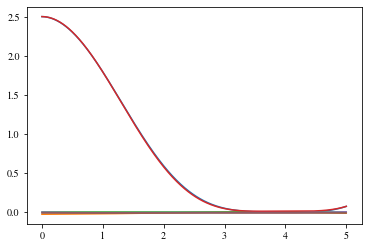

In [9]:

plt.plot(times,(Result_varDDTWA[0]),label="DDTWA $S_x$")
plt.plot(times,(Result_varDDTWA[1]),label="DDTWA $S_y$")
plt.plot(times,(Result_varDDTWA[2]),label="DDTWA $S_z$")


plt.plot(times,(Result_varDTWA[0]),label="DDTWA $S_x$")
plt.plot(times,(Result_varDTWA[1]),label="DDTWA $S_y$")
plt.plot(times,(Result_varDTWA[2]),label="DDTWA $S_z$")

In [10]:
gammaplus=Gamma_du/2
gammaminus=Gamma_decay/2
gammaz=Gamma_phi/4


Gamma_ud=2*gammaplus
Gamma_du=2*gammaminus
Gamma_el=8*gammaz


In [11]:
Gamma_ud=2*gammaplus
Gamma_du=2*gammaminus
Gamma_el=8*gammaz

Gamma_r=Gamma_ud+Gamma_du+1e-8


gamma=(Gamma_ud-Gamma_du)/4

Tot=Gamma_r+Gamma_el

lamda=Gamma_r/2

J01=J


s=2*1j*gamma+2*J01/N
r=0#Gamma_ud*Gamma_du

spp=2*1j*gamma+2*2*J01/N
spm=2*1j*gamma

def p0_gen(t):
    return  0.5*np.exp(-Tot*t/2)*( np.exp(-lamda*t)*( np.cos(t*(s**2-r)**0.5) +  lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5+1e-8)) )**(N-1)

def pp_gen(t):
    return  0.25*np.exp(-Tot*t)*( np.exp(-lamda*t)*( np.cos(t*(spp**2-r)**0.5) +  lamda*np.sin(t*(spp**2-r)**0.5)/((spp**2-r)**0.5+1e-8)) )**(N-2)

def pm_gen(t):
    return  0.25*np.exp(-Tot*t)*( np.exp(-lamda*t)*( np.cos(t*(spm**2-r)**0.5) +  lamda*np.sin(t*(spm**2-r)**0.5)/((spm**2-r+1e-8)**0.5)) )**(N-2)


def z0_gen(t):
    return 2*(Gamma_ud-Gamma_du)/(Gamma_ud+Gamma_du+1e-8)*np.exp(-Gamma_r*t/2)*np.sinh(Gamma_r*t/2) 

C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


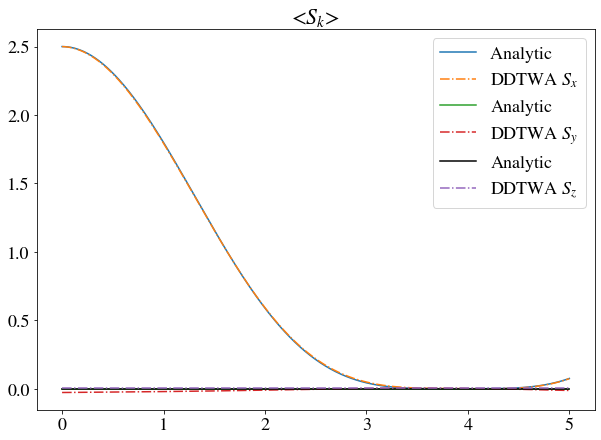

In [12]:
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.rcParams['font.size'] = 18



plt.title("<$S_k$>")


plt.plot(times,(N/2)*(p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic ")
plt.plot(times,(Result_varDDTWA[0]),"-.",label="DDTWA $S_x$")


plt.plot(times,-(N/2)*1j*(-p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic")
plt.plot(times,(Result_varDDTWA[1]),"-.",label="DDTWA $S_y$")


plt.plot(times,(N/2)*z0_gen(times),label="Analytic",c="k")
plt.plot(times,(Result_varDDTWA[2]),"-.",label="DDTWA $S_z$")

plt.legend()

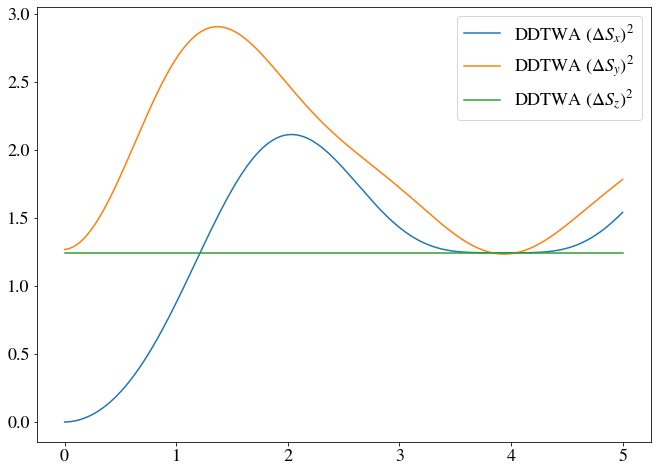

In [13]:
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)
ax=N/4+  Result_varDDTWA[3+0]-(Result_varDDTWA[0])**2
ay=N/4+  Result_varDDTWA[3+1]-(Result_varDDTWA[1])**2
az=N/4+  Result_varDDTWA[3+2]-(Result_varDDTWA[2])**2




plt.plot(times,ax,label="DDTWA $(\Delta S_x)^2$")
plt.plot(times,ay,label="DDTWA $(\Delta S_y)^2$")
plt.plot(times,az,label="DDTWA $(\Delta S_z)^2$")


plt.legend()

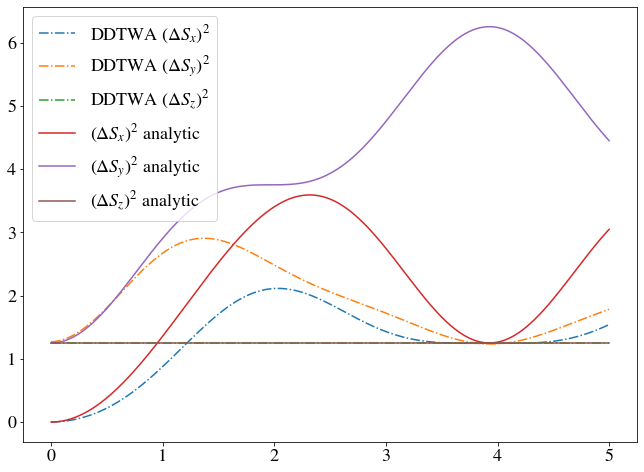

In [14]:
plt.plot(times,ax,"-.",label="DDTWA $(\Delta S_x)^2$")
plt.plot(times,ay,"-.",label="DDTWA $(\Delta S_y)^2$")
plt.plot(times,az,"-.",label="DDTWA $(\Delta S_z)^2$")

varX=(N/4)+(N*(N-1)/2)*( np.real(pp_gen(times)) + np.real(pm_gen(times)))-(N**2)*(np.real(p0_gen(times)))**2
varY=(N/4)+(N*(N-1)/2)*( -np.real(pp_gen(times)) + np.real(pm_gen(times)))-(N**2)*(np.imag(p0_gen(times)))**2
varZ=(N/4)*(1-(z0_gen(times))**2)




plt.plot(times,varX,label="$(\Delta S_x)^2$ analytic")
plt.plot(times,varY,label="$(\Delta S_y)^2$ analytic")
plt.plot(times,varZ,label="$(\Delta S_z)^2$ analytic")

plt.legend()

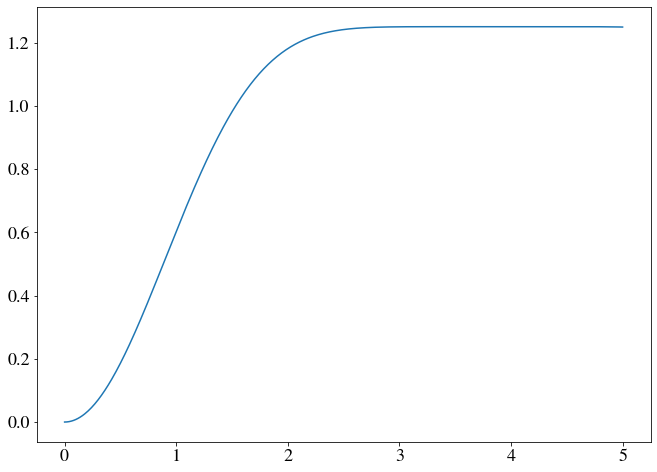

In [15]:
plt.plot(times,(N/4)*(1-4*(np.real(p0_gen(times)))**2))

In [16]:
import qutip
from qutip.piqs import *

import numpy as np
from qutip import sigmax, sigmay, sigmaz,tensor, qeye, Qobj
from qutip import basis
from qutip import sesolve

import matplotlib.pyplot as plt

#times1=times 
times1=times

n=N

def arraygen(n,A):
    Arr=[]
    for j in range(n):
        Arr.append(A)
    return Arr


def S_k(k,n=n):
    
    h=0*qeye(2**n)
    if k==0:
            
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmax()
            h=np.add(h,tensor(Arr))
    if k==1:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmay()
            h=np.add(h,tensor(Arr))
    if k==2:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmaz()
            h=np.add(h,tensor(Arr))
        
    
    return h/2
    

    
def matrix_dec(k,index,rate):
    h=0*qeye(2**N)
    sminus=(sigmax()-1j*sigmay())/2

    if k=="z":
        
        Arr=arraygen(N,qeye(2))
        Arr[index]=sigmaz()
        
        return Qobj(np.sqrt(rate)*np.add(h,tensor(Arr)))
    
    elif k=="-":
            
        Arr=arraygen(N,qeye(2))
        Arr[index]=sminus
        
        return Qobj(np.sqrt(rate)*np.add(h,tensor(Arr)))
    
    
    
    
def unc_list(k,rate):
    unc_list=[]
    for j in range(N):
        unc_list.append(matrix_dec(k,j,rate))
    
    return unc_list 
    
    
    
    
import matplotlib.pyplot as plt
import time

t0=time.time()

psi_init=np.cos(np.pi/4)*(basis(2,0)+basis(2,1))
#psi_init=basis(2,1)
psi0=Qobj(tensor(arraygen(n,psi_init)))

H=Qobj( (2*(J/n)*S_k(2,n)*S_k(2,n)+Omega*S_k(0,n))  )




def result():
    return sesolve(H, psi0, times1, [Qobj(S_k(0,n)),Qobj(S_k(1,n)),Qobj(S_k(2,n)),Qobj(S_k(0,n))**2,Qobj(S_k(1,n))**2,Qobj(S_k(2,n))**2])



result=result()

In [17]:
from qutip import mesolve
#result = mesolve(H, psi0, times, [np.sqrt(0.04) * Qobj(S_k(2,n))], [Qobj(S_k(0,n)),Qobj(S_k(1,n)),Qobj(S_k(2,n))])

Collapsing_Operators= unc_list("z",Gamma_phi/2)+unc_list("-",Gamma_decay) #[np.sqrt(Gamma_phi_C)*Qobj(S_k(2,N)),np.sqrt(Gamma_C)*Qobj(S_k("-",N))]  #Collective



result1 = mesolve(H, psi0, times, Collapsing_Operators, [Qobj(S_k(0,n)),Qobj(S_k(1,n)),Qobj(S_k(2,n))])


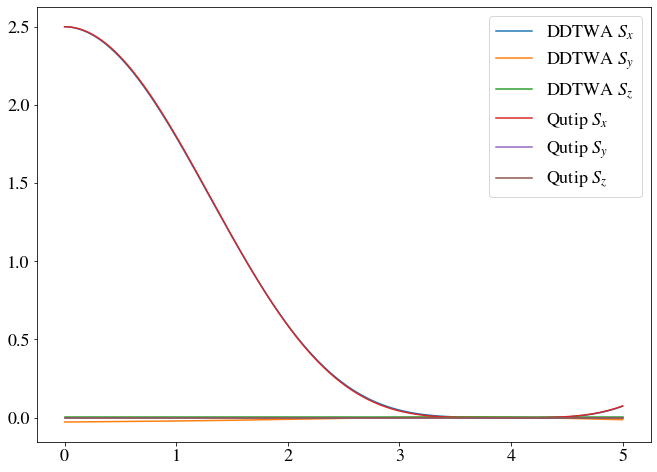

In [27]:
fig, ax = plt.subplots()

plt.plot(times,(Result_varDDTWA[0]),label="DDTWA $S_x$")
plt.plot(times,(Result_varDDTWA[1]),label="DDTWA $S_y$")
plt.plot(times,(Result_varDDTWA[2]),label="DDTWA $S_z$")

ax.plot(times, result1.expect[0],label="Qutip $S_x$")
ax.plot(times, result1.expect[1],label="Qutip $S_y$")
ax.plot(times, result1.expect[2],label="Qutip $S_z$")

#plt.plot(times,(N/2)*(p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic $S_x$")
#plt.plot(times,-(N/2)*1j*(-p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic $S_y$")
#plt.plot(times,(N/2)*z0_gen(times),label="Analytic $S_z$",c="k")

plt.legend()


In [ ]:

fig, ax = plt.subplots()
#ax.plot(times, result.expect[0])
#ax.plot(times, result.expect[1])
#ax.plot(times, result.expect[2])
ax.plot(times1, result.expect[3]-(result.expect[0])**2)
ax.plot(times1, result.expect[4]-(result.expect[1])**2)
ax.plot(times1, result.expect[5]-(result.expect[2])**2)



ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
ax.legend(("VarX", "VarY","VarZ",))

#plt.plot(times,(N/2)*(p0_gen(times) + np.conjugate(p0_gen(times)) ),"-.",label="Analytic")
#varX=(N/4)+(N*(N-1)/2)*( np.real(pp_gen(times1)) + np.real(pm_gen(times1)))-(N**2)*(np.real(p0_gen(times1)))**2
#varY=(N/4)+(N*(N-1)/2)*( -np.real(pp_gen(times1)) + np.real(pm_gen(times1)))-(N**2)*(np.imag(p0_gen(times1)))**2
#varZ=(N/4)*(1-(z0_gen(times1))**2)




#plt.plot(times1,varX,"--",label="$(\Delta S_x)^2$ analytic")
#plt.plot(times1,varY,"--",label="$(\Delta S_y)^2$ analytic")
#plt.plot(times1,varZ,"--",label="$(\Delta S_z)^2$ analytic")

plt.show()



In [ ]:
fig, ax = plt.subplots()

plt.plot(times,(Result_varDDTWA[0]),label="DDTWA $S_x$")
plt.plot(times,(Result_varDDTWA[1]),label="DDTWA $S_y$")
plt.plot(times,(Result_varDDTWA[2]),label="DDTWA $S_z$")

ax.plot(times, result.expect[0],label="Qutip $S_x$")
ax.plot(times, result.expect[1],label="Qutip $S_x$")
ax.plot(times, result.expect[2],label="Qutip $S_x$")


In [ ]:
gammaplus=Gamma_du/2
gammaminus=Gamma_decay/2
gammaz=Gamma_phi/4


Gamma_ud=2*gammaplus
Gamma_du=2*gammaminus
Gamma_el=8*gammaz

Gamma_r=Gamma_ud+Gamma_du+1e-8


gamma=(Gamma_ud-Gamma_du)/4

Tot=Gamma_r+Gamma_el

lamda=Gamma_r/2

J01=J


s=2*1j*gamma+2*J01/N
r=Gamma_ud*Gamma_du

def p0_gen(t):
    return  0.5*np.exp(-Tot*t/2)*( np.exp(-lamda*t)*( np.cos(t*(s**2-r)**0.5) +  lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5)) )**(N-1)

def z0_gen(t):
    return 2*(Gamma_ud-Gamma_du)/(Gamma_ud+Gamma_du+1e-8)*np.exp(-Gamma_r*t/2)*np.sinh(Gamma_r*t/2) 

In [ ]:
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)
index=2

plt.plot(times,N/4+  Result_varDDTWA[3+index]-(Result_varDDTWA[index])**2,label="DDTWA")
plt.plot(times,N/4+  Result_varDTWA[3+index]-(Result_varDTWA[index])**2,label="DTWA")
plt.plot(times,(N/4)*(1-(z0_gen(times))**2),"--",label="Analytic")

plt.legend()

In [ ]:
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)


plt.plot(times,N/4+  Result_varDDTWA[3+0]-(Result_varDDTWA[0])**2,label="DDTWA $(\Delta S_x)^2$")
plt.plot(times,N/4+  Result_varDDTWA[3+1]-(Result_varDDTWA[1])**2,label="DDTWA $(\Delta S_y)^2$")
plt.plot(times,N/4+  Result_varDDTWA[3+2]-(Result_varDDTWA[2])**2,label="DDTWA $(\Delta S_z)^2$")



plt.plot(times,N/4+  Result_varDTWA[3+0]-(Result_varDTWA[0])**2,label="DTWA $(\Delta S_x)^2$")
plt.plot(times,N/4+  Result_varDTWA[3+1]-(Result_varDTWA[1])**2,label="DTWA $(\Delta S_y)^2$")
plt.plot(times,N/4+  Result_varDTWA[3+2]-(Result_varDTWA[2])**2,label="DTWA $(\Delta S_z)^2$")

plt.legend()

In [ ]:
spm=2*1j*gamma


def pm_gen(t):
    return  0.25*np.exp(-Tot*t)*( np.exp(-lamda*t)*( np.cos(t*(spm**2-r)**0.5) +  lamda*np.sin(t*(spm**2-r)**0.5)/((spm**2-r)**0.5)) )**(N-2)


In [ ]:
Jpp=2*J

spp=2*1j*gamma+2*Jpp/N


def pp_gen(t):
    return  0.25*np.exp(-Tot*t)*( np.exp(-lamda*t)*( np.cos(t*(spp**2-r)**0.5) +  lamda*np.sin(t*(spp**2-r)**0.5)/((spp**2-r)**0.5)) )**(N-2)


In [ ]:
plt.plot(times,N/4+( (N**2-N)/2  )*(pp_gen(times)+pm_gen(times))  -(N**2)*(p0_gen(times))**2 ,label="Analytic")
plt.plot(times,N/4+  Result_varDDTWA[3+0]-(Result_varDDTWA[0])**2,label="DDTWA $(\Delta S_x)^2$")




plt.legend()

In [ ]:
def cr_norm(c):
    return (len(c)*mean(c))**2- (linalg.norm(c,2))**2

In [ ]:
cr_norm([1,2,3,4])

In [ ]:
import qutip
from qutip.piqs import *

import numpy as np
from qutip import sigmax, sigmay, sigmaz,tensor, qeye, Qobj
from qutip import basis
from qutip import sesolve

import matplotlib.pyplot as plt



n=5

def arraygen(n,A):
    Arr=[]
    for j in range(n):
        Arr.append(A)
    return Arr
    


def S_k(k,n=n):
    
    h=0*qeye(2**n)
    if k==0:
            
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmax()
            h=np.add(h,tensor(Arr))
    if k==1:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmay()
            h=np.add(h,tensor(Arr))
    if k==2:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmaz()
            h=np.add(h,tensor(Arr))
        
    
    return h
    

    
import matplotlib.pyplot as plt
import time

t0=time.time()


J=1
Omega=0
n=10

psi_init=np.cos(np.pi/4)*(basis(2,0)+basis(2,1))
psi0=Qobj(tensor(arraygen(n,psi_init)))

H=Qobj(2*(J/n)*S_k(2,n)*S_k(2,n)+Omega*S_k(0,n))

times = np.linspace(0.0, 4, 1000)


def result():
    return sesolve(H, psi0, times, [Qobj(S_k(0,n)/2),Qobj(S_k(1,n)/2),Qobj(S_k(2,n)/2)])





t1=time.time()


print(t1-t0)










import qutip
from qutip.piqs import *

import numpy as np
from qutip import sigmax, sigmay, sigmaz,tensor, qeye, Qobj
from qutip import basis
from qutip import sesolve

import matplotlib.pyplot as plt



n=5

def arraygen(n,A):
    Arr=[]
    for j in range(n):
        Arr.append(A)
    return Arr
    


def S_k(k,n=n):
    
    h=0*qeye(2**n)
    if k==0:
            
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmax()
            h=np.add(h,tensor(Arr))
    if k==1:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmay()
            h=np.add(h,tensor(Arr))
    if k==2:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmaz()
            h=np.add(h,tensor(Arr))
        
    
    return h
    

    
import matplotlib.pyplot as plt
import time

t0=time.time()


J=1
Omega=0
n=10

psi_init=np.cos(np.pi/4)*(basis(2,0)+basis(2,1))
psi0=Qobj(tensor(arraygen(n,psi_init)))

H=Qobj(2*(J/n)*S_k(2,n)*S_k(2,n)+Omega*S_k(0,n))

times = np.linspace(0.0, 4, 1000)


def result():
    return sesolve(H, psi0, times, [Qobj(S_k(0,n)/2),Qobj(S_k(1,n)/2),Qobj(S_k(2,n)/2)])

import qutip
from qutip.piqs import *

import numpy as np
from qutip import sigmax, sigmay, sigmaz,tensor, qeye, Qobj
from qutip import basis
from qutip import sesolve

import matplotlib.pyplot as plt



n=5

def arraygen(n,A):
    Arr=[]
    for j in range(n):
        Arr.append(A)
    return Arr
    


def S_k(k,n=n):
    
    h=0*qeye(2**n)
    if k==0:
            
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmax()
            h=np.add(h,tensor(Arr))
    if k==1:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmay()
            h=np.add(h,tensor(Arr))
    if k==2:
        for i in range(n):
            Arr=arraygen(n,qeye(2))
            Arr[i]=sigmaz()
            h=np.add(h,tensor(Arr))
        
    
    return h
    

    
import matplotlib.pyplot as plt
import time

t0=time.time()


J=1
Omega=0
n=10

psi_init=np.cos(np.pi/4)*(basis(2,0)+basis(2,1))
psi0=Qobj(tensor(arraygen(n,psi_init)))

H=Qobj(2*(J/n)*S_k(2,n)*S_k(2,n)+Omega*S_k(0,n))

times = np.linspace(0.0, 4, 1000)


def result():
    return sesolve(H, psi0, times, [Qobj(S_k(0,n)/2),Qobj(S_k(1,n)/2),Qobj(S_k(2,n)/2)])





t1=time.time()


print(t1-t0)



t1=time.time()


print(t1-t0)



fig, ax = plt.subplots()
ax.plot(4*times, result().expect[0])
ax.plot(4*times, result().expect[1])
ax.plot(4*times, result().expect[2])
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
ax.legend(("Sigma-X", "Sigma-Y","Sigma-Z",))

fig, ax2 = plt.subplots()
times = np.linspace(0., T, n)
ax2.plot(times,(Result_varDDTWA[0]),label="DDTWA $S_x$")

plt.show()

In [ ]:




gammaplus=Gamma_du/2
gammaminus=Gamma_decay/2
gammaz=Gamma_phi/4


Gamma=np.array([gammaplus,gammaminus,gammaz])  #[gamma+,gamma-,gammaz]


### Initial State

"""We consider by defect that the system starts in |0> for all the spins. The user can set the initial state as well."""
"""Recall that |0><0|=[[1,0],[0,0]]  """

"""The benchmark suggests that our initial state should be |psi(0)>=|+>"""


#t0=time.time()



def trace(A):
    return np.trace(A)

def matmu(A,B):
    return np.matmul(A,B)


rho_init0=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |1><1|
rho_init1=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |1><1|



#rho_init1=np.array([[1,0],[0,0]])    #By default
#rho_init2=np.array([[1,0],[0,0]])    #By default


sigma_p= np.array([[0,1],[0,0]])
sigma_m= np.array([[0,0],[1,0]])
sigma_z= np.array([[1,0],[0,-1]])


##Initial values one operator

sp_init0=trace(matmu(rho_init0,sigma_p))
sz_init0=trace(matmu(rho_init0,sigma_z))
sp_init1=trace(matmu(rho_init1,sigma_p))
sz_init1=trace(matmu(rho_init1,sigma_z))
sm_init1=trace(matmu(rho_init1,sigma_m))


##Initial values two-operators
## We assume initial separability of the state
#p0, z0, p1, z1 , p0p1, p0m1, z0p1, p0z1, z0z1 = z


sp_initp0p1=sp_init0*sp_init1
sz_initp0m1=sp_init0*sm_init1
sp_initz0p1=sz_init0*sp_init1
sz_initp0z1=sp_init0*sz_init1
sz_initz0z1=sz_init0*sz_init1




z0=np.array([sp_init0,sz_init0,sp_initp0p1,sz_initp0m1,sp_initz0p1,sz_initz0z1])



#t1=time.time()

#print(t1-t0)

#t0=time.time()

def cj(z): 
    return z.conjugate()

def real(z): 
    return z.real

def imag(z): 
    return z.imag


def dot_p(v1,v2):
    return np.dot(v1,v2)

from numba import jit

@jit

    # Define the right-hand-side of the differential equation.
def zfunc(z, t):
    p0, z0, p0p1, p0m1,   z0p1, z0z1 = z        
     
    
        
    dp0dt=-1j*(Omega/2)*z0+2*1j*(J/N)*(N-1)*z0p1    -(Gamma[0]+Gamma[1]+4*Gamma[2])*p0
        
    dz0dt= 2*Omega*np.imag(p0)+2*(Gamma[0]-Gamma[1])-2*(Gamma[0]+Gamma[1])*z0  
        
    dp0p1dt=-1j*Omega*z0p1+4*1j*(J/N)*(N-2)*(p0p1*z0+2*(z0p1-p0*z0)*p0)    -2*(Gamma[0]+Gamma[1]+4*Gamma[2])*p0p1

    dp0m1dt=-Omega*np.imag(z0p1)-2*(Gamma[0]+Gamma[1]+4*Gamma[2])*p0m1

    dz0p1dt=-1j*(Omega/2)*(2*(p0p1-p0m1)+z0z1)+  2*1j*(J/N)*( p0 + (N-2)*(z0z1*p0+2*(z0p1-z0*p0)*z0) )+2*(Gamma[0]-Gamma[1])*p0   
    dz0p1dt=dz0p1dt -(3*(Gamma[0]+Gamma[1])+4*Gamma[2])*z0p1
            
    dz0z1dt=  4*Omega*np.imag(z0p1)    - 4*(Gamma[1]-Gamma[0])*z0-4*(Gamma[0]+Gamma[1])*z0z1
        
        
        
        
    return [dp0dt, dz0dt, dp0p1dt, dp0m1dt, dz0p1dt, dz0z1dt] 

    # Set up the inputs and call odeintz to solve the system.

z, infodict = odeintz(zfunc, z0, times, full_output=1)
    
#t1=time.time()
#print(t1-t0)

In [ ]:
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)


plt.plot(times,N*(Result_varDDTWA[0])/2,"--",label="<$S_x$> DDTWA",linewidth=2.5)
plt.plot(times,N*(Result_varDDTWA[1])/2,"--",label="<$S_y$> DDTWA",linewidth=2.5)
plt.plot(times,N*(Result_varDDTWA[2])/2,"--",label="<$S_z$> DDTWA",c="k",linewidth=2.5)

plt.plot(times,N*(Result_varDTWA[0])/2,"-.",label="<$S_x$> DTWA",linewidth=2.5)
plt.plot(times,N*(Result_varDTWA[1])/2,"-.",label="<$S_y$> DTWA",linewidth=2.5)
plt.plot(times,N*(Result_varDTWA[2])/2,"-.",label="<$S_z$> DTWA",c="k",linewidth=2.5)



plt.plot(times,(N/2)*(p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic <$S_x$>")
plt.plot(times,-(N/2)*1j*(-p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic <$S_y$>")
plt.plot(times,(N/2)*z0_gen(times),label="Analytic <$S_z$>",c="y")





plt.xlim(0,times[-1])

plt.ylim()

plt.legend()

In [ ]:
Foss_z=(N/2)*z0_gen(times)

Dist_zDDTWA=np.linalg.norm(N*(Result_varDDTWA[2])/2-Foss_z,1)
Dist_zDTWA=np.linalg.norm(N*(Result_varDTWA[2])/2-Foss_z,1)
Dist_zCumul=np.linalg.norm((N/2)*(z[:,1])-Foss_z,1)



Foss_x=(N/2)*(p0_gen(times) + np.conjugate(p0_gen(times)) )

Dist_xDDTWA=np.linalg.norm(N*(Result_varDDTWA[0])/2-Foss_x,1)
Dist_xDTWA=np.linalg.norm(N*(Result_varDTWA[0])/2-Foss_x,1)
Dist_xCumul=np.linalg.norm((N/2)*(z[:,0]+np.conjugate(z[:,0]))-Foss_x,1)



Foss_y=-(N/2)*1j*(-p0_gen(times) + np.conjugate(p0_gen(times)) )

Dist_yDDTWA=np.linalg.norm(N*(Result_varDDTWA[1])/2-Foss_y,1)
Dist_yDTWA=np.linalg.norm(N*(Result_varDTWA[1])/2-Foss_y,1)
Dist_yCumul=np.linalg.norm((N/2)*1j*(-z[:,0]+np.conjugate(z[:,0]))-Foss_y,1)


Dist_DDTWA=(Dist_xDDTWA+Dist_yDDTWA+Dist_zDDTWA)
Dist_DTWA=(Dist_xDTWA+Dist_yDTWA+Dist_zDTWA)
Dist_Cumul=

In [ ]:
print("DDTWA ",Dist_DDTWA/n,"  DTWA ",Dist_DTWA/n, "   $\Gamma_{\phi}$", refgamma, "  \Gamma", refdecay)

In [ ]:
%timeit summary_stat(Testre,N,n)

In [ ]:
%timeit trayectory(N)

In [ ]:
Testre=trayectory(N)

In [ ]:
Tstre

In [ ]:
t0=time.time()

Iterations=10000


Result=averages(Iterations,N)


t1=time.time()

print(t1-t0)

In [ ]:
#from numba import jit

#@jit

def Sk(value):
    
    if value==0:  
        Sx=Result[0]
        for j in range(1,N):
            Sx=np.add(Sx,Result[j])
        return Sx/2
    elif value==1:
        Sy=Result[N]
        for j in range(1,N):
            Sy=np.add(Sy,Result[j+N])
        return Sy/2
    elif value==2:
        Sz=Result[2*N]
        for j in range(1,N):
            Sz=np.add(Sz,Result[j+2*N])
        return Sz/2
    


In [ ]:

gammaplus=Gamma_du/2
gammaminus=Gamma_decay/2
gammaz=Gamma_phi/4


Gamma=np.array([gammaplus,gammaminus,gammaz])  #[gamma+,gamma-,gammaz]


### Initial State

"""We consider by defect that the system starts in |0> for all the spins. The user can set the initial state as well."""
"""Recall that |0><0|=[[1,0],[0,0]]  """

"""The benchmark suggests that our initial state should be |psi(0)>=|+>"""


#t0=time.time()



def trace(A):
    return np.trace(A)

def matmu(A,B):
    return np.matmul(A,B)


rho_init0=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |1><1|
rho_init1=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |1><1|



#rho_init1=np.array([[1,0],[0,0]])    #By default
#rho_init2=np.array([[1,0],[0,0]])    #By default


sigma_p= np.array([[0,1],[0,0]])
sigma_m= np.array([[0,0],[1,0]])
sigma_z= np.array([[1,0],[0,-1]])


##Initial values one operator

sp_init0=trace(matmu(rho_init0,sigma_p))
sz_init0=trace(matmu(rho_init0,sigma_z))
sp_init1=trace(matmu(rho_init1,sigma_p))
sz_init1=trace(matmu(rho_init1,sigma_z))
sm_init1=trace(matmu(rho_init1,sigma_m))


##Initial values two-operators
## We assume initial separability of the state
#p0, z0, p1, z1 , p0p1, p0m1, z0p1, p0z1, z0z1 = z


sp_initp0p1=sp_init0*sp_init1
sz_initp0m1=sp_init0*sm_init1
sp_initz0p1=sz_init0*sp_init1
sz_initp0z1=sp_init0*sz_init1
sz_initz0z1=sz_init0*sz_init1




z0=np.array([sp_init0,sz_init0,sp_initp0p1,sz_initp0m1,sp_initz0p1,sz_initz0z1])



#t1=time.time()

#print(t1-t0)

#t0=time.time()

def cj(z): 
    return z.conjugate()

def real(z): 
    return z.real

def imag(z): 
    return z.imag


def dot_p(v1,v2):
    return np.dot(v1,v2)

from numba import jit

@jit

    # Define the right-hand-side of the differential equation.
def zfunc(z, t):
    p0, z0, p0p1, p0m1,   z0p1, z0z1 = z        
     
    
        
    dp0dt=-1j*(Omega/2)*z0+2*1j*(J/N)*(N-1)*z0p1    -(Gamma[0]+Gamma[1]+4*Gamma[2])*p0
        
    dz0dt= 2*Omega*np.imag(p0)+2*(Gamma[0]-Gamma[1])-2*(Gamma[0]+Gamma[1])*z0  
        
    dp0p1dt=-1j*Omega*z0p1+4*1j*(J/N)*(N-2)*(p0p1*z0+2*(z0p1-p0*z0)*p0)    -2*(Gamma[0]+Gamma[1]+4*Gamma[2])*p0p1

    dp0m1dt=-Omega*np.imag(z0p1)-2*(Gamma[0]+Gamma[1]+4*Gamma[2])*p0m1

    dz0p1dt=-1j*(Omega/2)*(2*(p0p1-p0m1)+z0z1)+  2*1j*(J/N)*( p0 + (N-2)*(z0z1*p0+2*(z0p1-z0*p0)*z0) )+2*(Gamma[0]-Gamma[1])*p0   
    dz0p1dt=dz0p1dt -(3*(Gamma[0]+Gamma[1])+4*Gamma[2])*z0p1
            
    dz0z1dt=  4*Omega*np.imag(z0p1)    - 4*(Gamma[1]-Gamma[0])*z0-4*(Gamma[0]+Gamma[1])*z0z1
        
        
        
        
    return [dp0dt, dz0dt, dp0p1dt, dp0m1dt, dz0p1dt, dz0z1dt] 

    # Set up the inputs and call odeintz to solve the system.

z, infodict = odeintz(zfunc, z0, times, full_output=1)
    
#t1=time.time()
#print(t1-t0)

In [ ]:
Gamma_ud=2*gammaplus
Gamma_du=2*gammaminus
Gamma_el=8*gammaz

Gamma_r=Gamma_ud+Gamma_du+1e-8


gamma=(Gamma_ud-Gamma_du)/4

Tot=Gamma_r+Gamma_el

lamda=Gamma_r/2

J01=J


s=2*1j*gamma+2*J01/N
r=Gamma_ud*Gamma_du

def p0_gen(t):
    return  0.5*np.exp(-Tot*t/2)*( np.exp(-lamda*t)*( np.cos(t*(s**2-r)**0.5) +  lamda*np.sin(t*(s**2-r)**0.5)/((s**2-r)**0.5)) )**(N-1)


def z0_gen(t):
    return 2*(Gamma_ud-Gamma_du)/(Gamma_ud+Gamma_du+1e-8)*np.exp(-Gamma_r*t/2)*np.sinh(Gamma_r*t/2) 

# DTWA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




from numba import jit

@jit

def trayectorydtwa(N=N):
    
    
    
    


    Results =zeros((3*N, n))

    for j in range(N):
        a=(choices([-1,1]))[0]
        b=(choices([-1,1]))[0]
        Results[j][0]=1   #state |+>
        Results[j+N][0]=a
        Results[j+2*N][0]=b


    for t in range(n-1):
        for i in range(N): 
            Normal_VA=random.randn()#np.random.normal(0, 1)
        
            Results[i][t+1]     = Results[i][t]+dt*(-Gamma_phi-(Gamma_decay/2) )*Results[i][t]
            
            Results[i+N][t+1]   = Results[i+N][t]+dt*(-Omega*Results[i+2*N][t] -(Gamma_phi+ (Gamma_decay/2))*Results[i+N][t])
            
            Results[i+2*N][t+1] = Results[i+2*N][t]+dt*( Omega*Results[i+N][t] - Gamma_decay*(Results[i+2*N][t]+1) )
            
            for j in range(N):
                if i!=j:
                    Results[i][t+1]=Results[i][t+1]-2*Results[i+N][t]*(J/N)*Results[j+2*N][t]*dt
                    Results[i+N][t+1]=Results[i+N][t+1]+ 2*Results[i][t]*(J/N)*Results[j+2*N][t]*dt
                    
                    
            
            
    return Results


In [ ]:
from numba import jit

@jit

def averagesddtwa(itera,N):
    
    Average=zeros((3*N, n))
    for j in range(itera):
        Average=add(Average,trayectorydtwa(N))
    return Average/itera
    

In [ ]:
t0=time.time()

Iterations=10000


Resultdtwa=averagesddtwa(Iterations,N)


t1=time.time()

print(t1-t0)

In [ ]:
#from numba import jit

#@jit

def Skdtwa(value):
    
    if value==0:  
        Sx=Resultdtwa[0]
        for j in range(1,N):
            Sx=np.add(Sx,Resultdtwa[j])
        return Sx/2
    elif value==1:
        Sy=Resultdtwa[N]
        for j in range(1,N):
            Sy=np.add(Sy,Resultdtwa[j+N])
        return Sy/2
    elif value==2:
        Sz=Resultdtwa[2*N]
        for j in range(1,N):
            Sz=np.add(Sz,Resultdtwa[j+2*N])
        return Sz/2
    


# Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

## Distances summary

In [ ]:
plt.title("<$S_z$>")

plt.plot(times,(N/2)*(z[:,1]),label="Cumulant")
plt.plot(times,Sk(2),label="DDTWA")
plt.plot(times,Skdtwa(2),label="DTWA")
plt.plot(times,(N/2)*z0_gen(times),label="Analytic")


plt.legend()

In [ ]:
Foss_z=(N/2)*z0_gen(times)

Dist_zDDTWA=np.linalg.norm(Sk(2)-Foss_z,1)
Dist_zDTWA=np.linalg.norm(Skdtwa(2)-Foss_z,1)
Dist_zCumul=np.linalg.norm((N/2)*(z[:,1])-Foss_z,1)






print("DDTWA ",Dist_zDDTWA/n,"  DTWA ",Dist_zDTWA/n, "  Cumulant ", Dist_zCumul)

In [ ]:
plt.title("<$S_x$>")

plt.plot(times,(N/2)*(z[:,0]+np.conjugate(z[:,0])),label="Cumulant")
plt.plot(times,Sk(0),label="DDTWA")
plt.plot(times,Skdtwa(0),label="DTWA")
plt.plot(times,(N/2)*(p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic")


plt.legend()

In [ ]:
Foss_x=(N/2)*(p0_gen(times) + np.conjugate(p0_gen(times)) )

Dist_xDDTWA=np.linalg.norm(Sk(0)-Foss_x,1)
Dist_xDTWA=np.linalg.norm(Skdtwa(0)-Foss_x,1)
Dist_xCumul=np.linalg.norm((N/2)*(z[:,0]+np.conjugate(z[:,0]))-Foss_x,1)






print("DDTWA ",Dist_xDDTWA/n,"  DTWA ",Dist_xDTWA/n, "  Cumulant ", Dist_xCumul/n)

In [ ]:
plt.title("<$S_y$>")

plt.plot(times,(N/2)*1j*(-z[:,0]+np.conjugate(z[:,0])),label="Cumulant")
plt.plot(times,Sk(1),label="D$\,$DTWA")
plt.plot(times,Skdtwa(1),label="DTWA")
plt.plot(times,-(N/2)*1j*(-p0_gen(times) + np.conjugate(p0_gen(times)) ),label="Analytic")


plt.legend()

In [ ]:
Foss_y=-(N/2)*1j*(-p0_gen(times) + np.conjugate(p0_gen(times)) )

Dist_yDDTWA=np.linalg.norm(Sk(1)-Foss_y,1)
Dist_yDTWA=np.linalg.norm(Skdtwa(1)-Foss_y,1)
Dist_yCumul=np.linalg.norm((N/2)*1j*(-z[:,0]+np.conjugate(z[:,0]))-Foss_y,1)



print("DDTWA ",Dist_yDDTWA/n,"  DTWA ",Dist_yDTWA/n, "  Cumulant ", Dist_yCumul/n)

## Total Distance

In [ ]:
Dist_DDTWA=Dist_xDDTWA+Dist_yDDTWA+Dist_zDDTWA
Dist_DTWA=Dist_xDTWA+Dist_yDTWA+Dist_zDTWA
Dist_Cumul=Dist_xCumul+Dist_yCumul+Dist_zCumul


print("DDTWA ",Dist_DDTWA/n,"  DTWA ",Dist_DTWA/n, "  Cumulant ", Dist_Cumul/n, "   $\Gamma_{\phi}$", refgamma, "  \Gamma", refdecay)

DDTWA  0.14653531979630047   DTWA  0.86360335092438   Cumulant  6.73455569491864    $\Gamma_{\phi}$ 0.0   \Gamma 0.05
DDTWA  0.19402629166683236   DTWA  0.5168239017297126   Cumulant  4.638963031336165    $\Gamma_{\phi}$ 0.05   \Gamma 0.05
DDTWA  0.22244307690743054   DTWA  0.5012654150337356   Cumulant  3.2215857281920615    $\Gamma_{\phi}$ 0.1   \Gamma 0.05
DDTWA  0.06112523467017385   DTWA  0.3835364679801429   Cumulant  2.256514410306027    $\Gamma_{\phi}$ 0.15   \Gamma 0.05
DDTWA  0.11631514958704228   DTWA  0.26857363071206913   Cumulant  1.5947499950377728    $\Gamma_{\phi}$ 0.2   \Gamma 0.05
DDTWA  0.16587660426806564   DTWA  0.19442277248743203   Cumulant  1.1375699864827882    $\Gamma_{\phi}$ 0.25   \Gamma 0.05

DDTWA  0.31767600228096693   DTWA  1.5336851335173758   Cumulant  4.457197561597242    $\Gamma_{\phi}$ 0.0   \Gamma 0.1
DDTWA  0.32538232746933593   DTWA  1.0585822737283654   Cumulant  3.08847265536392    $\Gamma_{\phi}$ 0.05   \Gamma 0.1
DDTWA  0.19055059096098262   DTWA  0.8703811282775037   Cumulant  2.1582835782146863    $\Gamma_{\phi}$ 0.1   \Gamma 0.1
DDTWA  0.16928505382843353   DTWA  0.6916339698857314   Cumulant  1.5217310895687635    $\Gamma_{\phi}$ 0.15   \Gamma 0.1
DDTWA  0.2307662122348709   DTWA  0.49660354431608894   Cumulant  1.0829178538398088    $\Gamma_{\phi}$ 0.2   \Gamma 0.1

